In [2]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

def calculate_metrics(true_values, pred_values):
    mse = round(mean_squared_error(true_values, pred_values),3)
    mae = round(mean_absolute_error(true_values, pred_values),3)
    r_score = round(r2_score(true_values, pred_values),3)

    return {"mse": mse,
            "mae": mae,
            "r^2": r_score,}

In [3]:
import h2o
from h2o.automl import H2OAutoML

# Start the H2O cluster (locally)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 21.0.1+12-LTS-29, mixed mode, sharing)
  Starting server from C:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\38066\AppData\Local\Temp\tmp752oniwi
  JVM stdout: C:\Users\38066\AppData\Local\Temp\tmp752oniwi\h2o_38066_started_from_python.out
  JVM stderr: C:\Users\38066\AppData\Local\Temp\tmp752oniwi\h2o_38066_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Kiev
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 12 days
H2O_cluster_name:,H2O_from_python_38066_ia8q9n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.952 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [6]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_logP_01.02_v3.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

unimportant_features_to_drop = []
X, y = dataPreparation.prepare_data_for_RF(is_pKa=False,
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=True,
                                           outliers_features_to_skip=unimportant_features_to_drop)

correlated_features = ['f_atom_fraction', 'naHRing', 'nFaRing', 'nFaHRing', 'tpsa+f']
features_to_drop = []
for feature_name in X.columns:
    if feature_name in correlated_features or "angle" in feature_name:
        features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

X = X.fillna(0)
poly = PolynomialFeatures(degree=2, interaction_only=False)
X_poly = poly.fit_transform(X)
poly_column_names = poly.get_feature_names_out(X.columns)
X = pd.DataFrame(X_poly, columns=poly_column_names, index=X.index)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=False,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

train = h2o.H2OFrame(train_df)
test = h2o.H2OFrame(test_df)

True
183
['nC', 'FPSA3', 'nFARing', 'RPCS', 'dipole_moment', 'angle_R1X1R2', 'nFAHRing', 'angle_X2X1R1', 'nFHRing', 'naHRing', 'chirality', 'cis/trans', 'nHRing', 'TASA', 'angle_X1X2R2', 'nO', 'nF', 'PNSA5', 'dihedral_angle', 'f_atom_fraction', 'f_to_fg', 'nARing', 'angle_R2X2R1', 'identificator', 'naRing', 'nFaRing', 'nFaHRing', 'mol_volume', 'tpsa+f', 'mol_weight', 'avg_atoms_in_cycle', 'mol_num_cycles', 'nN', 'nAHRing', 'PBF', 'nFRing', 'WPSA5', 'f_freedom', 'distance_between_atoms_in_f_group_centers', 'PPSA5', 'GeomShapeIndex', 'pKa', 'logP']
dipole_moment [19, 21, 23, 27, 61, 66, 67, 73, 82, 136, 152, 182]
f_atom_fraction [124]
mol_volume [127]
distance_between_atoms_in_f_group_centers [168]
logP [82, 83]
Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       173, 174, 175, 176, 177, 178, 179, 180, 181, 182],
      dtype='int64', length=183)
Remains rows:97, amount of features: 43
81 16
Parse progress: |██████████████████████████████████████████████████████████

In [23]:
x = train.columns
# x.remove('C1')
y = "logP"
x.remove(y)

# train[y] = train[y].asfactor()
# test[y] = test[y].asfactor()

aml = H2OAutoML(seed=1, max_runtime_secs_per_model=300)
aml.train(x=x, y=y, training_frame=train, leaderboard_frame=test, fold_column="fold_id")

# View the AutoML Leaderboard
lb = aml.leaderboard
print(lb.head(rows=lb.nrows))

AutoML progress: |


23:09:40.438: Fold column fold_id will be used for cross-validation. nfolds parameter will be ignored.
23:09:40.440: AutoML: XGBoost is not available; skipping it.
23:09:40.448: _train param, Dropping bad and constant columns: [nN, 1, nFHRing chirality, nFAHRing chirality, nN^2, nFHRing cis/trans, nFAHRing cis/trans]


23:09:41.97: _train param, Dropping bad and constant columns: [nN, 1, nFHRing chirality, nFAHRing chirality, nN^2, nFHRing cis/trans, nFAHRing cis/trans]
23:09:41.97: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 138.0.
23:09:41.101: _train param, Dropping bad and constant columns: [nN, 1, nFHRing chirality, nFAHRing chirality, nN^2, nFHRing cis/trans, nFAHRing cis/trans]

███
23:09:44.741: _train param, Dropping bad and constant columns: [nN, 1, nFHRing chirality, nFAHRing chirality, nN^2, nFHRing cis/trans, nFAHRing cis/trans]

██
23:09:46.416: _train param, Dropping bad and constant

In [18]:
best_prev_model = h2o.load_model(r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\h2o_model\models\25.01.24_features\pKa\Only_mol_with_angles_without_outliers(except_dipole)_with_angles(as features)\DeepLearning_grid_3_AutoML_1_20240126_235839_model_3')

top_features = []
for feature_index in range(15):
    top_features.append(best_prev_model.varimp()[feature_index][0])
top_features

unimportant_features_to_drop = []
for feature_name in X.columns:
    if feature_name not in top_features:
        unimportant_features_to_drop.append(feature_name)

unimportant_features_to_drop

['dipole_moment',
 'nHRing',
 'avg_atoms_in_cycle',
 'angle_R2X2R1',
 'nF',
 'nFRing',
 'f_freedom',
 'mol_num_cycles',
 'nFAHRing',
 'distance_between_atoms_in_f_group_centers',
 'nC',
 'nAHRing',
 'mol_volume',
 'nFaRing',
 'nFHRing',
 'angle_X2X1R1',
 'nFaHRing',
 'RPCS',
 'naRing',
 'nFARing',
 'naHRing',
 'chirality',
 'nARing']

TEST metrics:

In [9]:
best_model = aml.get_best_model()
preds = best_model.predict(test)
true = test.as_data_frame()['logP']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

deeplearning prediction progress: |

██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.012, 'mae': 0.078, 'r^2': 0.95}

TRAIN metrics

In [25]:
best_model = aml.get_best_model()
preds = best_model.predict(train)
true = train.as_data_frame()['logP']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.016, 'mae': 0.088, 'r^2': 0.95}

In [26]:
best_model

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_1_AutoML_2_20240201_230940_model_18


Status of Neuron Layers: predicting logP, regression, gaussian distribution, Quadratic loss, 10 461 weights/biases, 201,6 KB, 1 381 380 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate              rate_rms                momentum    mean_weight            weight_rms           mean_bias            bias_rms
--  -------  -------  ----------------  ---------  ----  ----  ---------------------  ----------------------  ----------  ---------------------  -------------------  -------------------  -----------------------
    1        521      Input             20.0
    2        20       RectifierDropout  50.0       0.0   0.0   0.0631062267097017     0.049764782190322876    0.0         0.0021330063339587337  0.2485484480857849   -1.9918455868019227  2.0581226348876953
    3        1        Linear                       0.0   0.0   7.797161670168862e-05  1.8163824279326946e-05  0.0         0.004403626639395952   0.02100595086812973  0.05342354246293319  1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.015826293284540497
RMSE: 0.1258025964936356
MAE: 0.08782434426161276
RMSLE: 0.04869434060755443
Mean Residual Deviance: 0.015826293284540497

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 0.09946813817449746
RMSE: 0.3153856974792888
MAE: 0.22692438803809098
RMSLE: 0.11475595786748806
Mean Residual Deviance: 0.09946813817449746

Cross-Validation Metrics Summary: 
                        mean      sd         cv_1_valid    cv_2_valid
----------------------  --------  ---------  ------------  ------------
mae                     0.228653  0.0210814  0.243559      0.213746
mean_residual_deviance  0.101349  0.0229432  0.117572      0.0851258
mse                     0.101349  0.0229432  0.117572      0.0851258
r2                      0.661018  0.140901   0.561386      0.76065
residual_deviance       0.101349  0.0229432  0.117572      0.0851258
rmse                    0.317326  0.0361509  0.342888      0.291763
rmsle                   0.115487  0.0236163  0.132186      0.0987879

Scoring History: 
    timestamp            duration           training_speed    epochs    iterations    samples      training_rmse    training_deviance    training_mae    training_r2
--  -------------------  -----------------  ----------------  --------  ------------  -----------  ---------------  -------------------  --------------  -------------
    2024-02-01 23:31:14  0.000 sec                            0         0             0            nan              nan                  nan             nan
    2024-02-01 23:31:14  20 min 43.488 sec  81176 obs/sec     10        1             1380         0.411481         0.169317             0.307729        0.468437
    2024-02-01 23:31:19  20 min 48.494 sec  79462 obs/sec     2890      289           398820       0.142516         0.0203109            0.105403        0.936235
    2024-02-01 23:31:24  20 min 53.495 sec  80592 obs/sec     5850      585           807300       0.112133         0.0125738            0.0803171       0.960525
    2024-02-01 23:31:29  20 min 58.497 sec  81425 obs/sec     8860      886           1.22268e+06  0.151434         0.0229321            0.11347         0.928006
    2024-02-01 23:31:31  21 min  0.394 sec  81690 obs/sec     10010     1001          1.38138e+06  0.125803         0.0158263            0.0878243       0.950314

Variable Importances: 
variable                                             relative_importance    scaled_importance    percentage
---------------------------------------------------  ---------------------  -------------------  ---------------------
chirality identificator                              1.0                    1.0                  0.0075353841623499234
f_to_fg f_freedom                  

In [8]:
best_model = h2o.load_model(r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\h2o_model\models\01.02.24_features_2.1\logP\all_molecules_using_PolynomialFeatures(with_interaction_without_angle_feature)_without_outliers\DeepLearning_grid_1_AutoML_2_20240201_230940_model_18')

preds = best_model.predict(test)
true = test.as_data_frame()['logP']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.012, 'mae': 0.078, 'r^2': 0.95}

PERMUTATION IMPORTANCE

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
C:\Users\38066\AppData\Local\Temp\ipykernel_14908\2639209905.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.barh(sum_rows.keys()[sorted_idx][::-1][:30][::-1], sum_rows[sorted_idx][::-1][:30][::-1])


Text(0.5, 0, 'H2O Feature Importance')

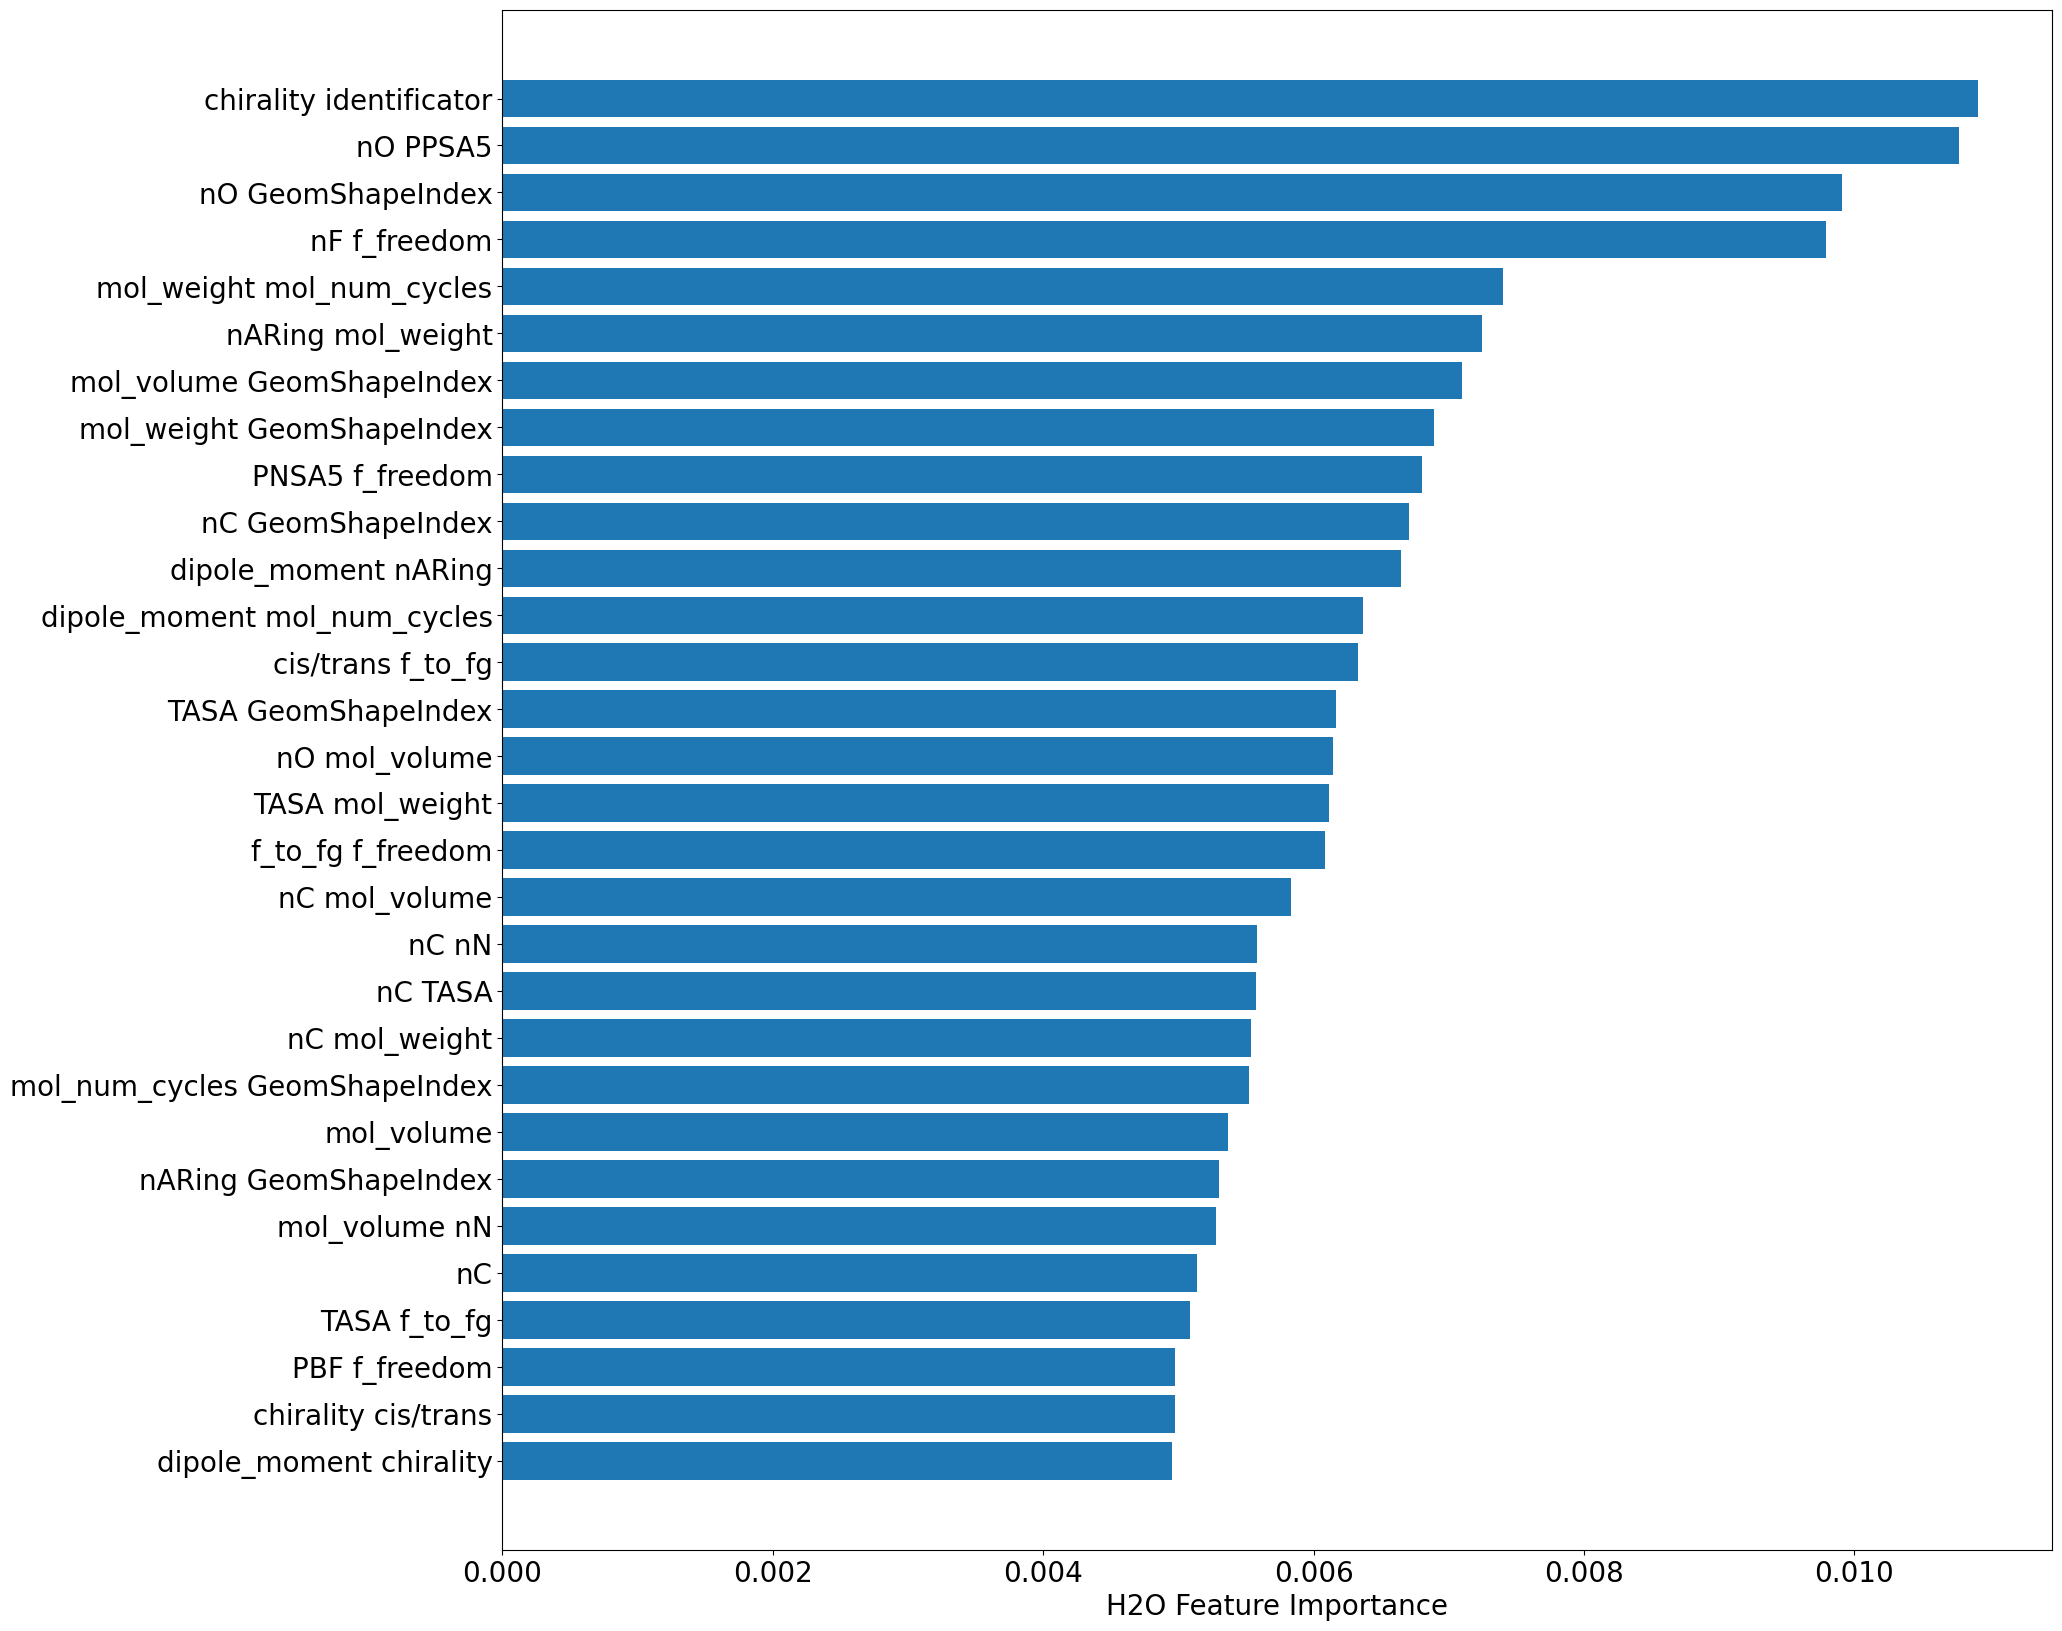

In [27]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

permutation_varimp = best_model.permutation_importance(test, use_pandas=True, n_repeats=100)

sum_rows = permutation_varimp.sum(axis=1)
sum_rows = sum_rows / sum(sum_rows)

sorted_idx = sum_rows.argsort()
plt.figure(figsize=(20,20))
plt.barh(sum_rows.keys()[sorted_idx][::-1][:30][::-1], sum_rows[sorted_idx][::-1][:30][::-1])
plt.xlabel("H2O Feature Importance")

SHAP

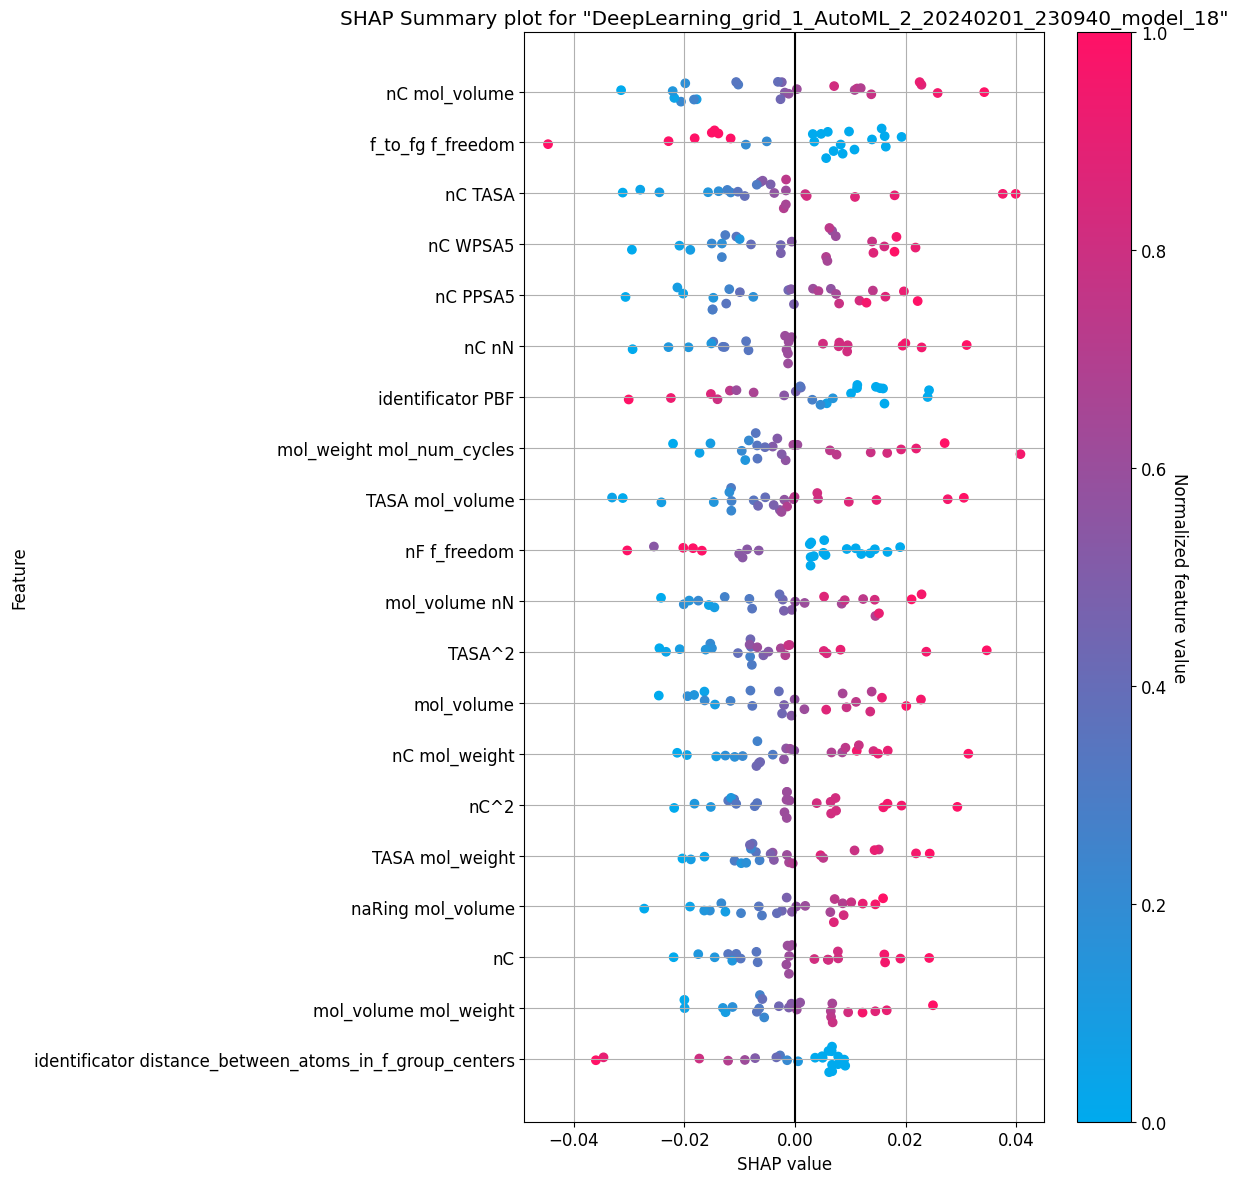

In [28]:
plt.rcParams.update({"font.size": 12})
shap_plot = best_model.shap_summary_plot(test, background_frame=train, samples=2000)

VAR IMPORTANCE

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Text(0.5, 0, 'Percent')

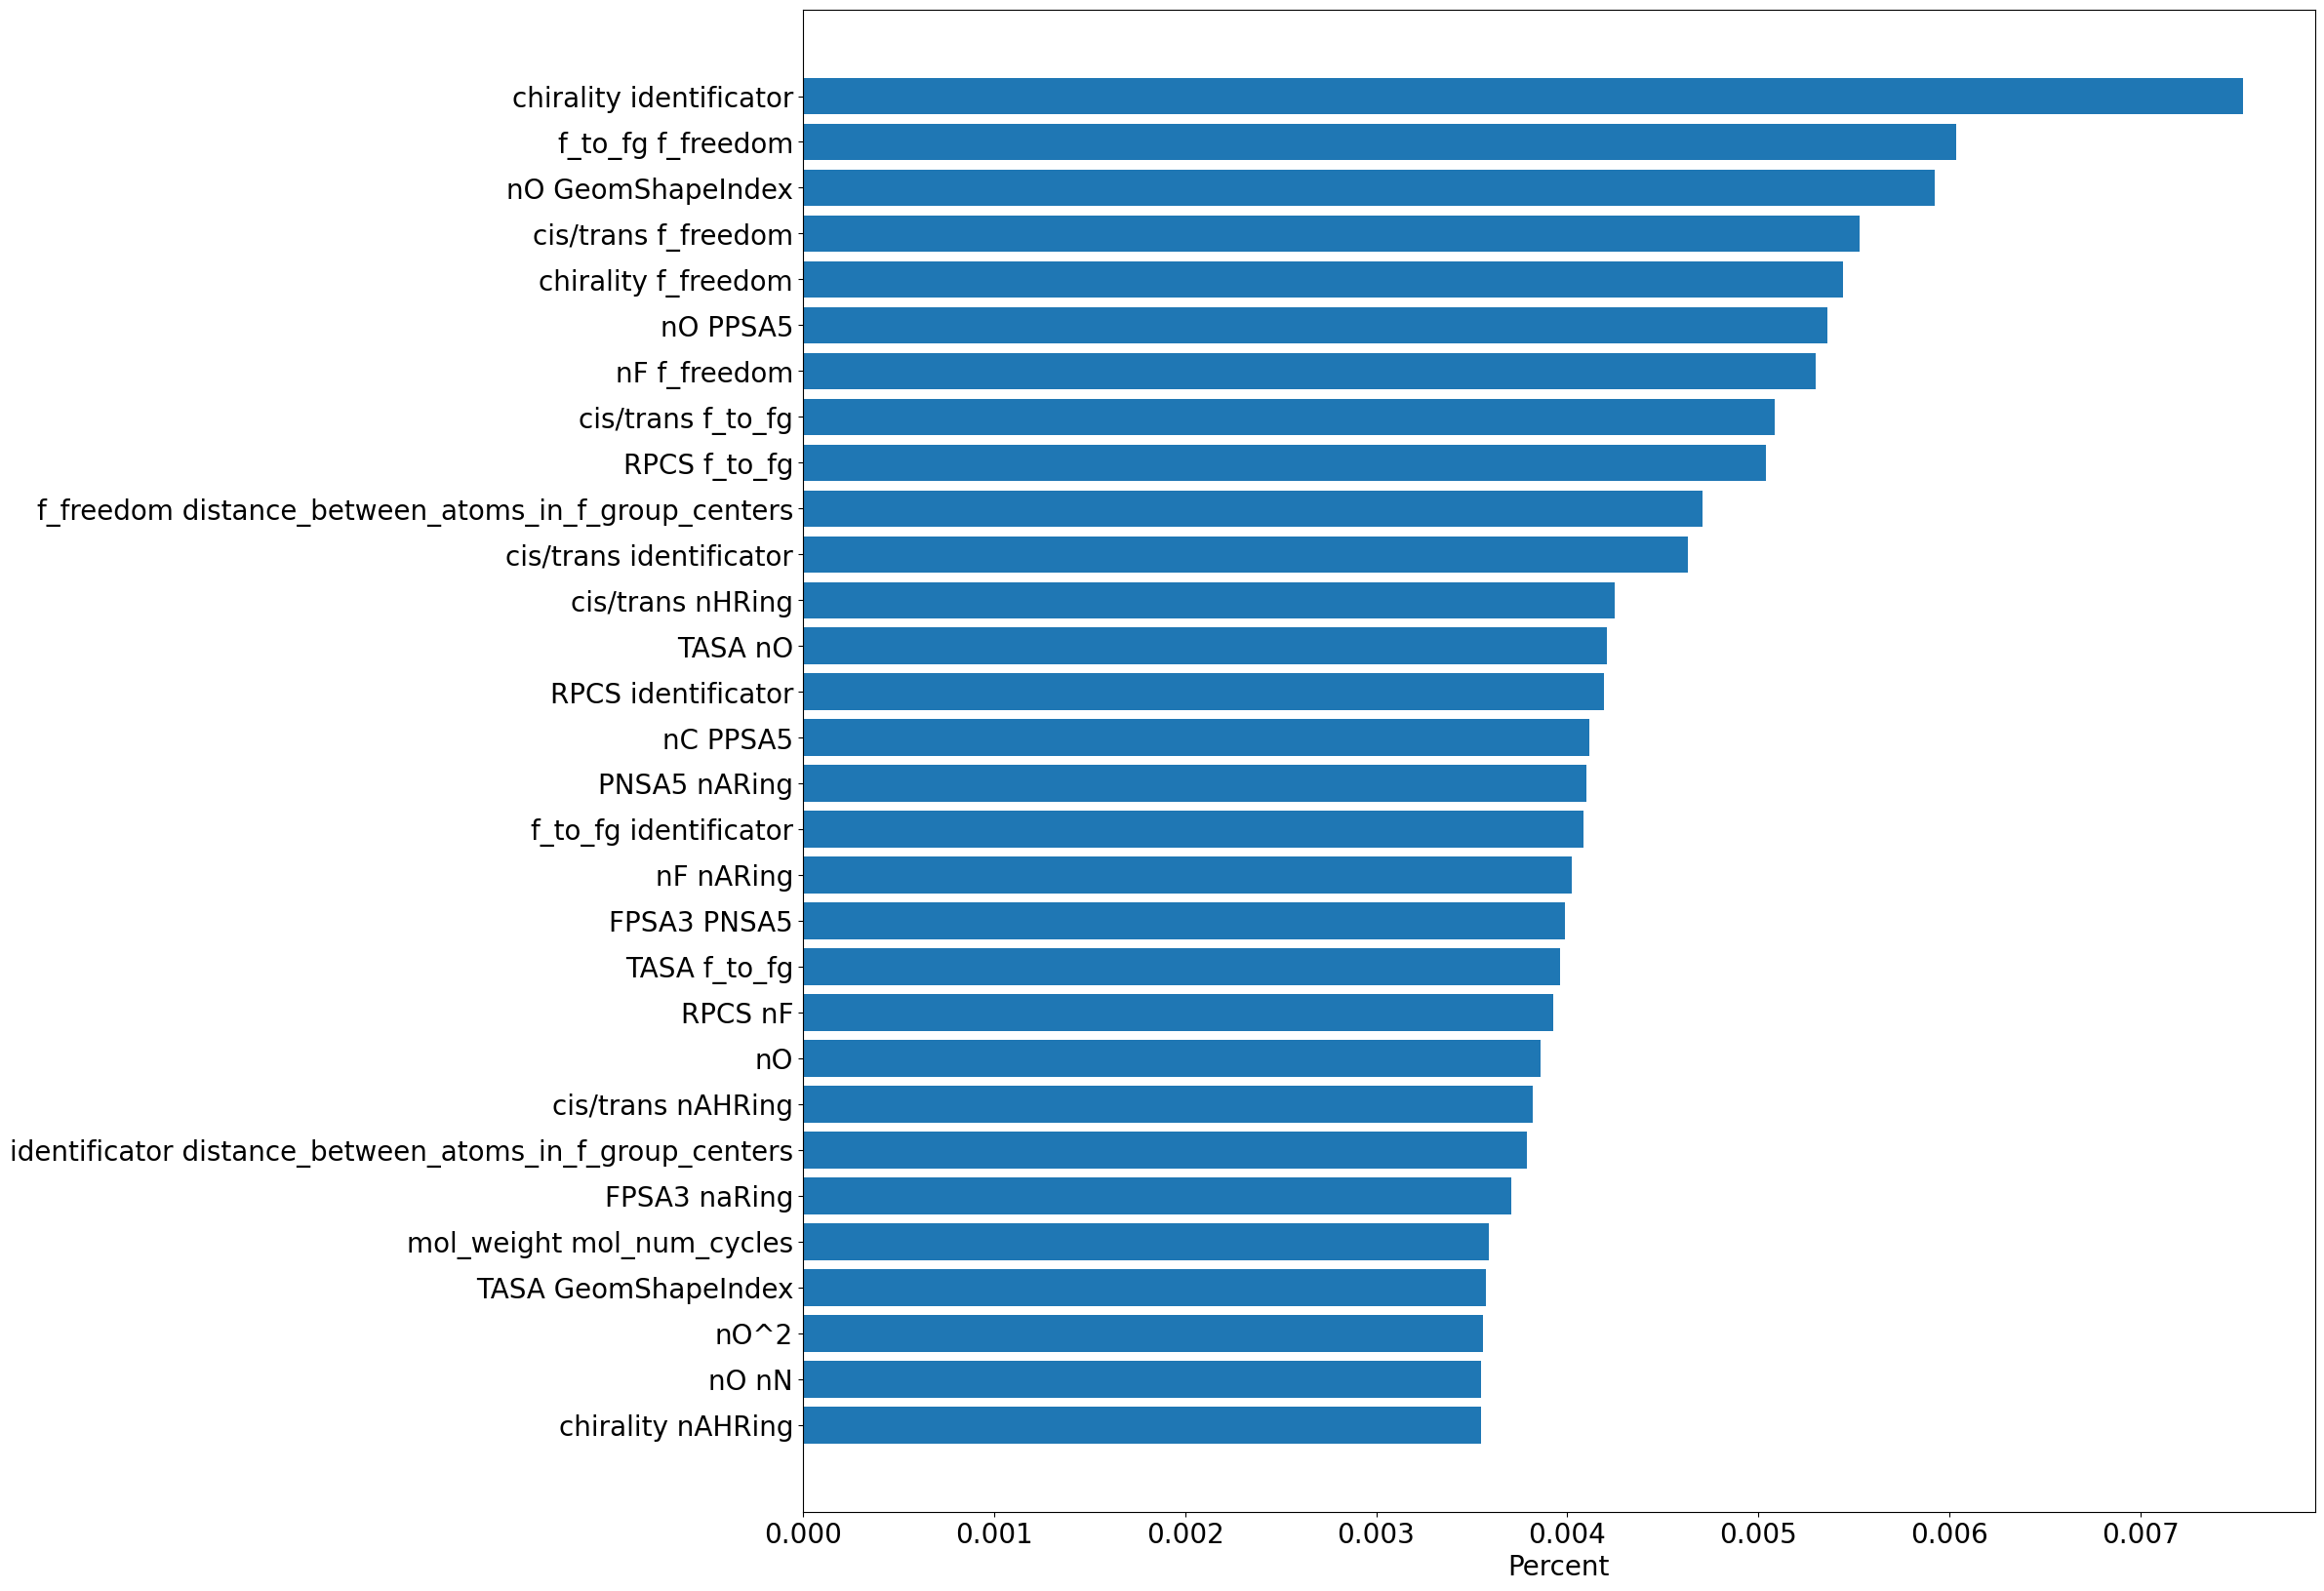

In [32]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

preds = best_model.predict(test)
true = test.as_data_frame()['logP']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

importance = best_model.varimp(test)

fig, ax = plt.subplots(figsize=(20, 20))
ax.barh(importance['variable'][:30][::-1], importance['percentage'][:30][::-1])
ax.set_xlabel('Percent')


BEST MODEL SAVING

In [29]:
import os

MODEL_SAVE_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\h2o_model\models\01.02.24_features_2.1\logP'

best_model = aml.get_best_model()

model_path = h2o.save_model(model=best_model, path=os.path.join(MODEL_SAVE_PATH, 'all_molecules_using_PolynomialFeatures(with_interaction_without_angle_feature)_without_outliers'), force=True)
model_path

'C:\\work\\DrugDiscovery\\main_git\\XAI_Chem\\ml_part\\h2o_model\\models\\01.02.24_features_2.1\\logP\\all_molecules_using_PolynomialFeatures(with_interaction_without_angle_feature)_without_outliers\\DeepLearning_grid_1_AutoML_2_20240201_230940_model_18'